# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Luca Fetz  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

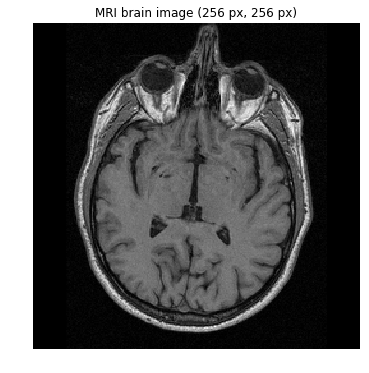

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
In this implementation of region growing i chose a local homogeneity criterion (difference between frontier pixel and its neighbor under a threshold). The brain is quite well detected, but the region has many holes. Area is simply computed as sum of accepted pixels. To make it smoother we could apply a closing morphological operator or we could change the homogeneity criterion to consider the mean and std of our accepted pixels.

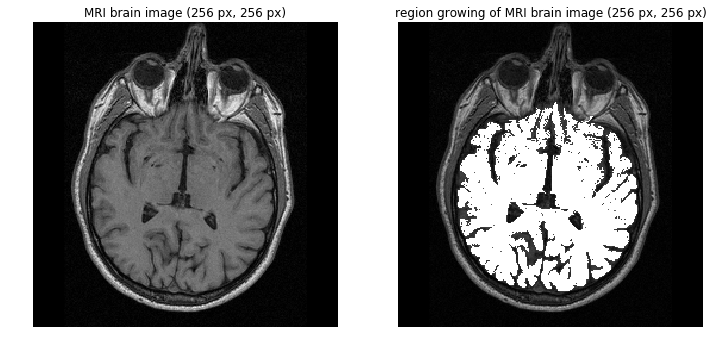

The brain is 14350 pixels wide.


In [25]:
#region growing method. Start somewhere and recursively see if neighboring pixels satisfy homogeneity criterion
#homogeneity threshold: intensity between twe neighbors lower than threshold
#stard point: 128,140
#threshold = 10 #used for the local homogeneity
threshold = 16 #used for the mean homogeneity
area, old_area = 1, 0
x,y = 128, 140
region_g = brain_im.copy()
#table with 0 not visited, 1 visited and part of the region, 2 visited and part of the frontier, 3 visited and not part of the region
visit_table = np.zeros((im_h,im_w),dtype = int)
visit_table[x][y] = 2

mean = region_g[x][y]

while old_area < area:
    old_area = area
    #look in image where we need to visit neighbors
    for k in range(1, im_h-1):#all image except last lines and columns which won't have unvisited neighbors
        for l in range(1,im_w-1):
            if visit_table[k][l] == 2: #if it is part of the frontier we look at its neighbors
                visit_table[k][l] = 1 #set as visited
                for i in range(k-1, k+2):#range begins at k-1 and ends at k+1
                    for j in range(l-1,l+2):
                        if visit_table[i][j] == 0: #neighbors not yet visited
#                            homo = abs(int(region_g[i][j]) - int(region_g[k][l]))
#                            if homo < threshold:
                            homo = abs(int(region_g[i][j]) - mean)
                            if homo < threshold:
                                area = area + 1
                                visit_table[i][j] = 2
                                mean = (mean*(area-1) + region_g[i][j])/area
                            else: 
                                visit_table[i][j] = 3


for k in range(0, im_h):#go through image and saturate pixels detected as brain
    for l in range(0,im_w):
        if visit_table[k][l] == 1 or visit_table[k][l] == 2:
            region_g[k][l] = 255
        
        
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(region_g, cmap='gray')
ax[1].set_title('region growing of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

print('The brain is {} pixels wide.' .format(area))

### 1.3 Contour detection
Here the code is based on the active_contour function provided by skimage.segmentation. The contour detection depends a lot on the snake initialisation. If the circle is bigger than the skull, the contour won't look for the brain at all, it will converge at the skull. It makes sense because the skull is also an object with more or less the same edge properties. We can control the snake to look for black or white, to give more importance to edges or smoothness, but this can't help us differenciate the brain from the skull. If the initial circle is inside the brain it works much better.

Inside the brain there are a lot of edges that can trap the snake in local minima. To avoid this, a high weight is given to beta to try to capture the smooth round shape of the brain. Still if the initialisation is too small, the edge of the brain will be too far away to be detected by the derivatives, they will show gradient toward local minima.

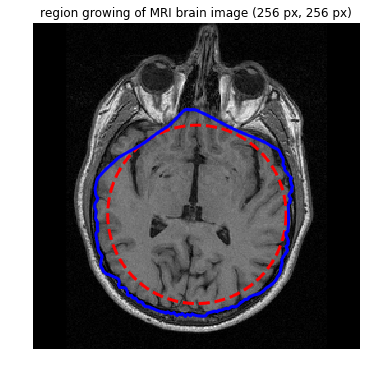

estimated area = 12732.395447351626


In [4]:
#Active contour with skimage
import skimage.segmentation as seg
#copy original image
active_contour = brain_im.copy()
#initialize snake as a circle
s = np.linspace(0, 2*np.pi, 400)
x = 128 + 70*np.cos(s)
y = 150 + 70*np.sin(s)
snake_init = np.array([x, y]).T
#apply active contour on active_contour image with snake_init as initial contour
#alpha: resistance to stretching. Here put to 0 because we expect the snake to stretch since snake_init is inside the brain
#beta: rigidity: resistance to bending. High value to capture the smooth round shape of the brain
#w_line controls attraction to brightness. Negative to attract to dark region (region between brain and skull)
#w_edge: controls attraction to edges
snake = seg.active_contour(active_contour, snake_init,alpha=0, beta=100, w_line=-2, w_edge=1.5, bc='periodic', max_px_move=2.0, max_iterations=5000)

#plot result
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(active_contour, cmap='gray')
ax.plot(snake_init[:, 0], snake_init[:,1],'--r', lw=3)
ax.plot(snake[:, 0], snake[:,1],'-b', lw=3)
ax.set_title('region growing of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

#approximate area by area of a circle with the same perimeter
r = snake.shape[0]/(2*np.pi)
area = np.pi*r*r
print('estimated area = {}'.format(area))

### 1.4 Additional method(s)
In this part a simple thresholding is implemented based on histogram results. It doesn't work so well as some parts of the skull has the same intensity as the brain. To try to improve results and exclude the skull pixels, a morphological opening with a smoothed square is used. After this operation, the resulting area is closer to previous results.

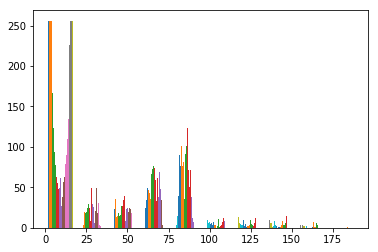

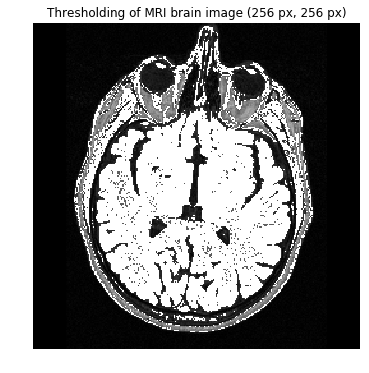

Calculated area: 19612


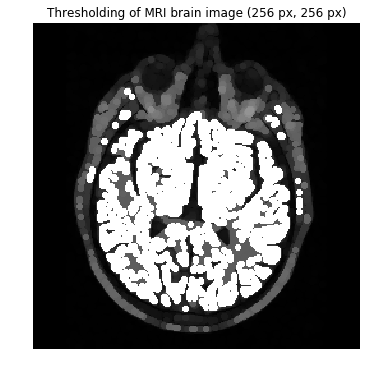

Calculated area: 14384


In [5]:
import skimage.exposure as expo
import skimage.morphology as morph
threshold = brain_im.copy()
plt.hist(threshold) #histogram to see where to put threshold. Brain should be between 55 and 90.
area = 0
for k in range(0, im_h):#saturates pixel if detected as brain by the threshold
    for l in range(0,im_w):
        if threshold[k][l] >= 55 and threshold[k][l] <= 90:
            threshold[k][l] = 255
            area = area+1

#plot result
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(threshold, cmap='gray')
ax.set_title('Thresholding of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()
print('Calculated area: {}'.format(area))

#try excluding outliers and improve results with morphology
area = 0
struct_elem = np.array([[0,1,1,1,0], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [0,1,1,1,0]])
out = morph.opening(threshold,struct_elem)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(out, cmap='gray')
ax.set_title('Thresholding of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

for k in range(0, im_h):#go through image and compute number of saturated pixels
    for l in range(0,im_w):
        if out[k][l] == 255:
            area = area+1

print('Calculated area: {}'.format(area))

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [6]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


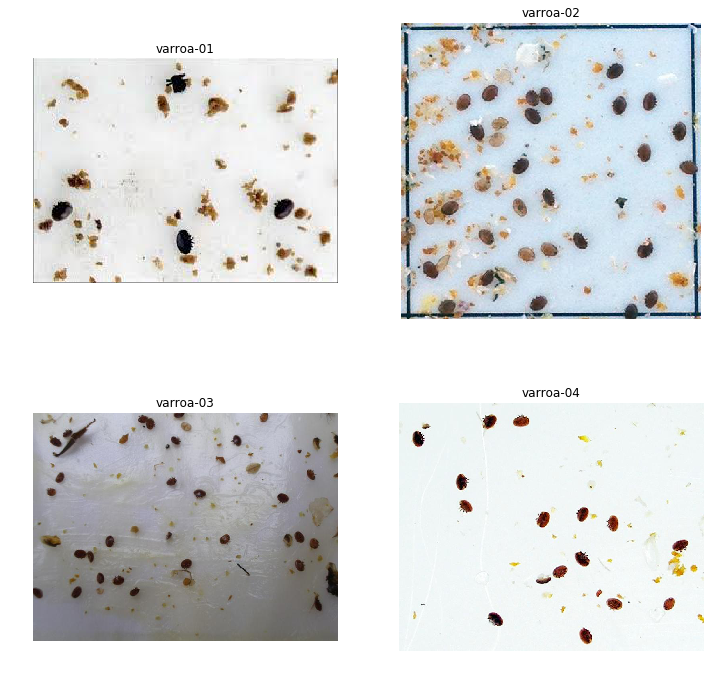

In [7]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [8]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [9]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

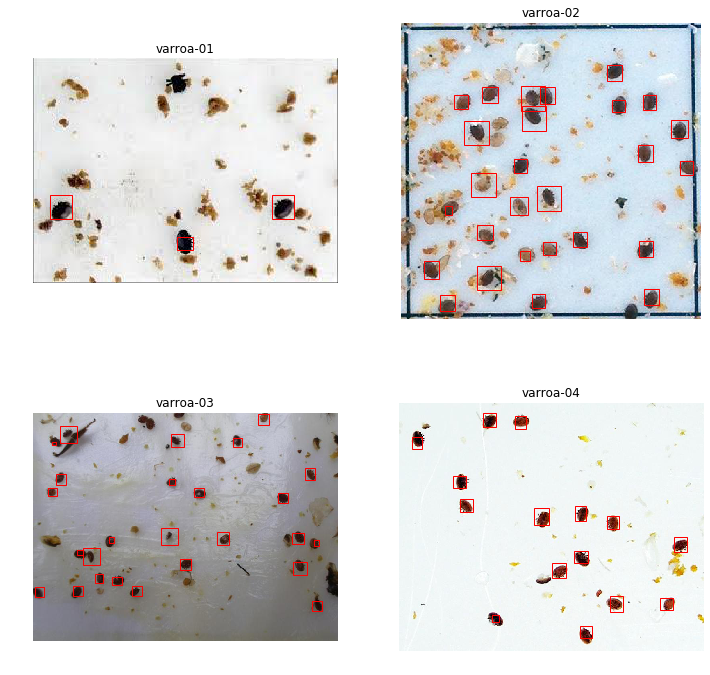

In [10]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

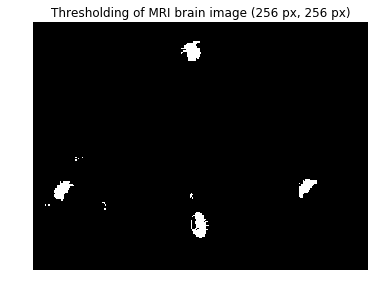

In [23]:
import skimage.filters as filt

def thresholding(image,thres1,thres2):
    im_h, im_w = image.shape
    for k in range(0, im_h):#saturates pixel if detected as brain by the threshold
        for l in range(0,im_w):
            if image[k][l] >= thres1 and image[k][l] <= thres2:
                image[k][l] = 255
            else:
                image[k][l] = 0
    return image

def dark_hysteresis_thresholding(image,thres1,thres2):
    im_h, im_w = image.shape
    for k in range(0, im_h):#saturates pixel if detected as brain by the threshold
        for l in range(0,im_w):
            image[k][l] = 255 - image[k][l]
            
    out = filt.apply_hysteresis_threshold(image,255 - thres1,255 - thres2)
    return out
                

gamma_p = 0.5
img_gamma = skimage.exposure.adjust_gamma(img_color, gamma=gamma_p, gain=1)

thresImage = ic[0][:,:,0].copy()
#thresImage2 = ic[0][:,:,0].copy()
thresImage = thresholding(thresImage,0,35)
#thresImage2 = dark_hysteresis_thresholding(thresImage2,40,35)


#plot result
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(thresImage, cmap='gray')
ax.set_title('Thresholding of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


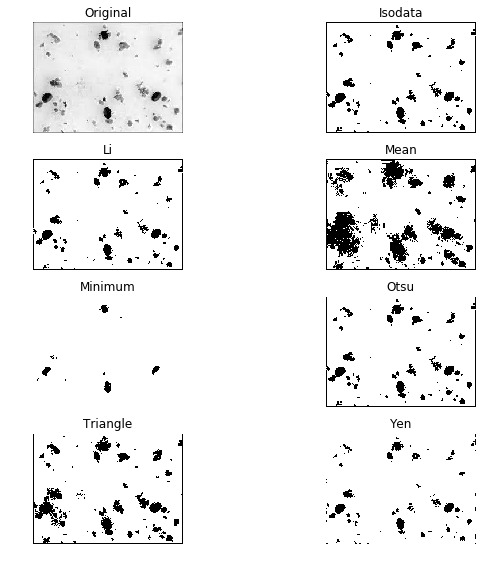

In [27]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold

img =ic[0][:,:,0].copy()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion